# OBJECTIVE :- Apply K-NN on Amazon Fine Food Reviews Dataset

# Note :- I am completing this assignment with only 40K datapoints as my laptop got hang on 100K datapoints.

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


# Random Sampling Of Dataset

In [10]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 40k datapoints

# We will collect different 40k rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:40000])
print(my_final.shape)
my_final.head()

(40000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
102985,111851,B000KOSH2Y,ANKCM346FMZZD,Melissa Bernard,1,1,positive,1335744000,My Favorite Chili Seasoning!,This chili seasoning is the best and it makes ...,chili season best make make chili easi use veg...
213868,231784,B0002W2F9K,A2WOOHJ0MZTQAI,"OptimusPrimerib ""OptimusPrimerib""",0,1,positive,1222300800,Best Canned coffee out there,This is the finest coffee for caf&eacute; con ...,finest coffe con lech stovetop coffe make etc ...
450464,487049,B000PDWBKO,A3G523R8W642DE,vawn,0,0,positive,1324944000,Taste like movie theater popcorn.,I was really suprised at how good it tasted. ...,realli supris good tast kernel didnt pop defin...
256336,277898,B001E53WIW,A3UJO1INDG2XBF,AMT1008,0,0,positive,1246406400,excellent service,I am addicted to this tea - hot & iced - and h...,addict tea hot ice difficult time find price g...
266640,289033,B00275QB0Y,AMBJQQSRCAOHS,Scott_Andrews,0,0,positive,1322870400,Love the taste,"Love the natural smoke flavor, adds great flav...",love natur smoke flavor add great flavor meat ...


In [11]:
# Sample dataset 
my_final['Score'].value_counts()

positive    33674
negative     6326
Name: Score, dtype: int64

In [12]:
# Original dataset
final['Score'].value_counts()

positive    307028
negative     57108
Name: Score, dtype: int64

In [13]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(my_final[my_final['Score'] == 'positive'])/len(my_final[my_final['Score'] == 'negative'])

5.323110970597534

In [14]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 'positive'])/len(final[final['Score'] == 'negative'])

5.37626952440989

OBSERVATION FOR RATIO : Ratio of positive reviews to negative reviews in Sample Dataset is approximately similar to ratio of positive reviews to negative reviews in Original Dataset

 SPLITTING OF SAMPLE DATASET INTO TRAIN_DATA AND TEST_DATA

In [15]:
from sklearn.model_selection import train_test_split


x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# (1). Bag of Words (BoW)


In [16]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (28000, 1988)
the number of unique words : 1988


# 3 Fold Cross-Validation (Brute force implementation)

In [17]:
# Importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_vec, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 9.


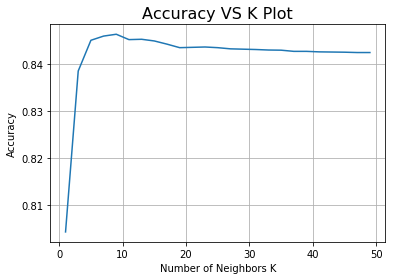


 Accuracy for each k value is :  [0.804 0.839 0.845 0.846 0.846 0.845 0.845 0.845 0.844 0.844 0.844 0.844
 0.844 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843
 0.843]


In [18]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [19]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_brute_K = optimal_k
bow_brute_train_acc = max(cv_scores)*100
bow_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 9 is 84.483333%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

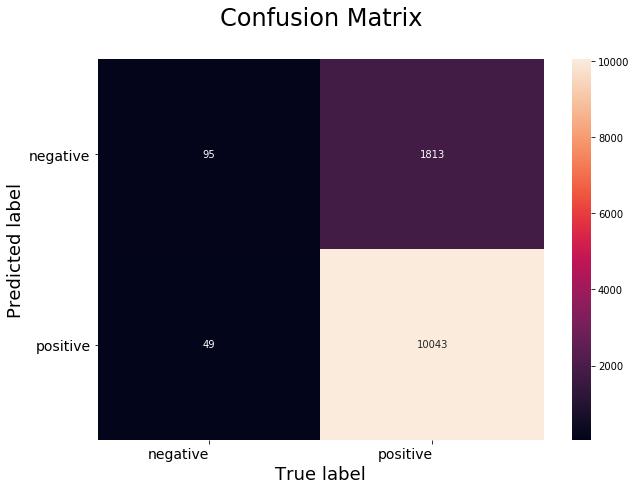

In [20]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3 Fold Cross-Validation (kd_tree implementation)

In [21]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_vec)
X_test_vec_dense = svd.transform(X_test_vec)


# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


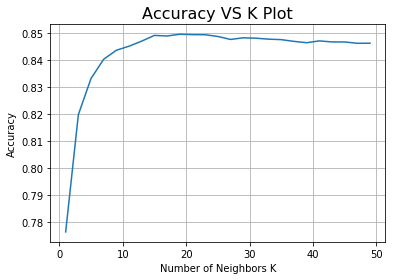


 Accuracy for each k value is :  [0.776 0.82  0.833 0.84  0.844 0.845 0.847 0.849 0.849 0.85  0.849 0.849
 0.849 0.848 0.848 0.848 0.848 0.848 0.847 0.846 0.847 0.847 0.847 0.846
 0.846]


In [22]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [23]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_kdTree_K = optimal_k
bow_kdTree_train_acc = max(cv_scores)*100
bow_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 85.075000%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

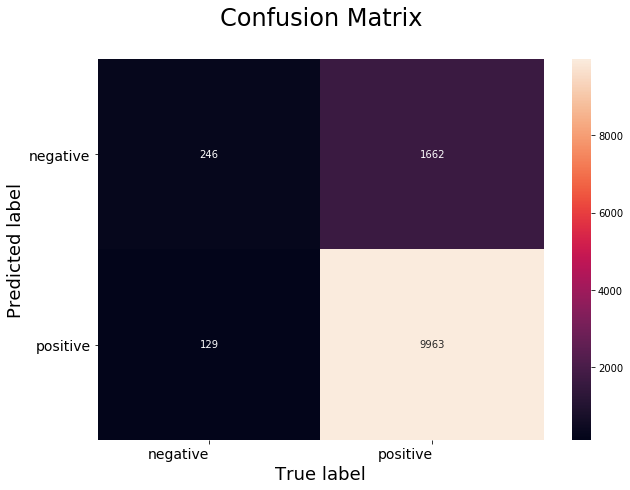

In [24]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (2). TF-IDF

In [25]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (28000, 1988)
the number of unique words : 1988


# 3 Fold Cross-Validation (Brute force implementation)

In [26]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_vec, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 13.


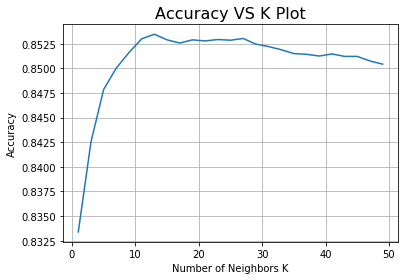


 Accuracy for each k value is :  [0.833 0.843 0.848 0.85  0.852 0.853 0.853 0.853 0.853 0.853 0.853 0.853
 0.853 0.853 0.852 0.852 0.852 0.851 0.851 0.851 0.851 0.851 0.851 0.851
 0.85 ]


In [27]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [28]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_brute_K = optimal_k
tfidf_brute_train_acc = max(cv_scores)*100
tfidf_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 13 is 84.916667%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

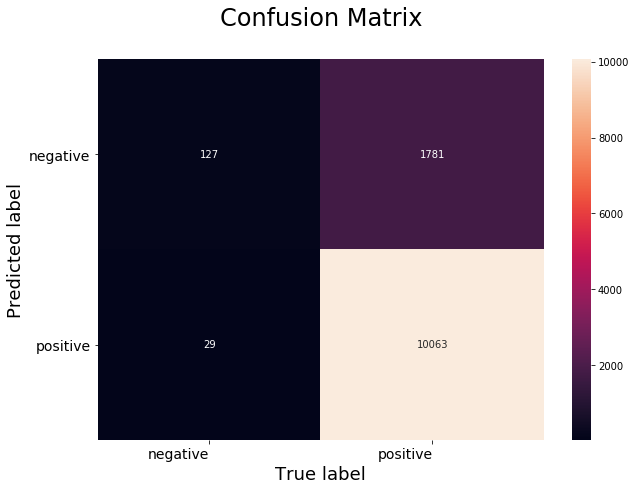

In [29]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3 Fold Cross-Validation (kd_tree implementation)

In [30]:
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_vec)
X_test_vec_dense = svd.transform(X_test_vec)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 45.


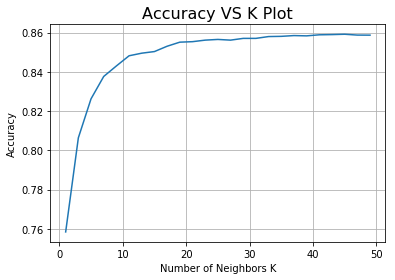


 Accuracy for each k value is :  [0.758 0.806 0.826 0.838 0.843 0.848 0.85  0.85  0.853 0.855 0.855 0.856
 0.857 0.856 0.857 0.857 0.858 0.858 0.858 0.858 0.859 0.859 0.859 0.859
 0.859]


In [31]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [32]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_kdTree_K = optimal_k
tfidf_kdTree_train_acc = max(cv_scores)*100
tfidf_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 45 is 85.600000%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

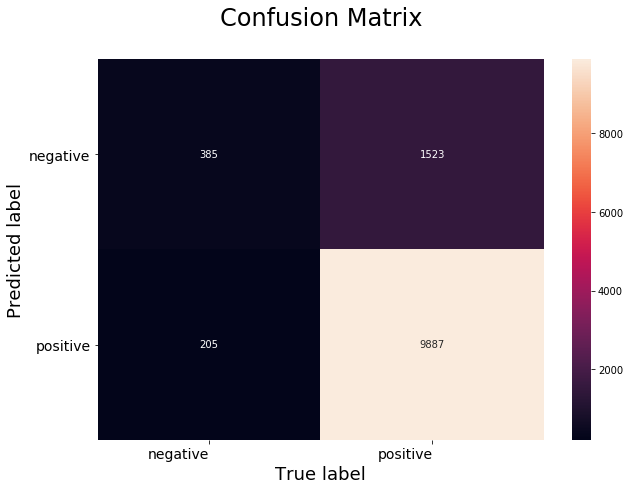

In [33]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Word2Vec

In [34]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  7211


# (3). Avg Word2Vec

In [35]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)    

# 3 Fold Cross-Validation (Brute force implementation)

In [36]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 15.


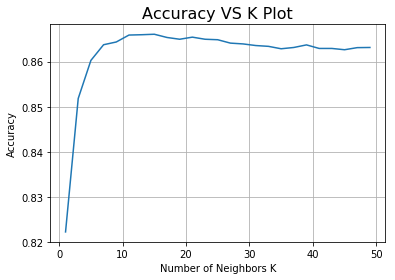


 Accuracy for each k value is :  [0.822 0.852 0.86  0.864 0.864 0.866 0.866 0.866 0.865 0.865 0.865 0.865
 0.865 0.864 0.864 0.864 0.863 0.863 0.863 0.864 0.863 0.863 0.863 0.863
 0.863]


In [37]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [38]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_brute_K = optimal_k
Avg_Word2Vec_brute_train_acc = max(cv_scores)*100
Avg_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 15 is 86.858333%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

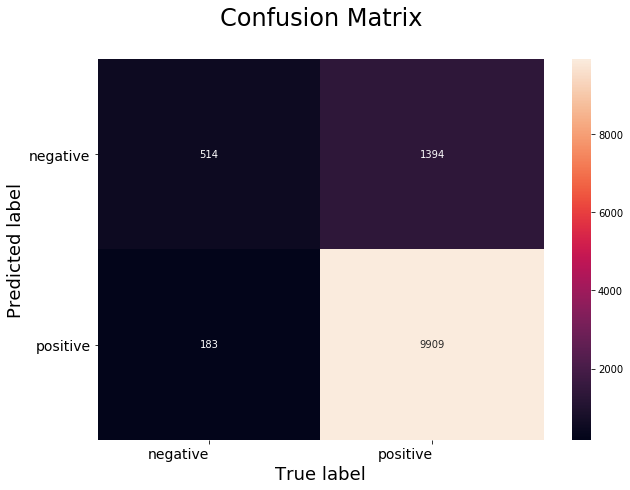

In [39]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3 Fold Cross-Validation (kd_tree implementation)

In [40]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 15.


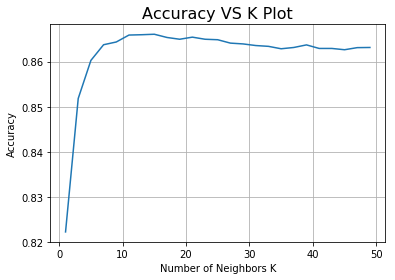


 Accuracy for each k value is :  [0.822 0.852 0.86  0.864 0.864 0.866 0.866 0.866 0.865 0.865 0.865 0.865
 0.865 0.864 0.864 0.864 0.863 0.863 0.863 0.864 0.863 0.863 0.863 0.863
 0.863]


In [41]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [42]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_kdTree_K = optimal_k
Avg_Word2Vec_kdTree_train_acc = max(cv_scores)*100
Avg_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 15 is 86.858333%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

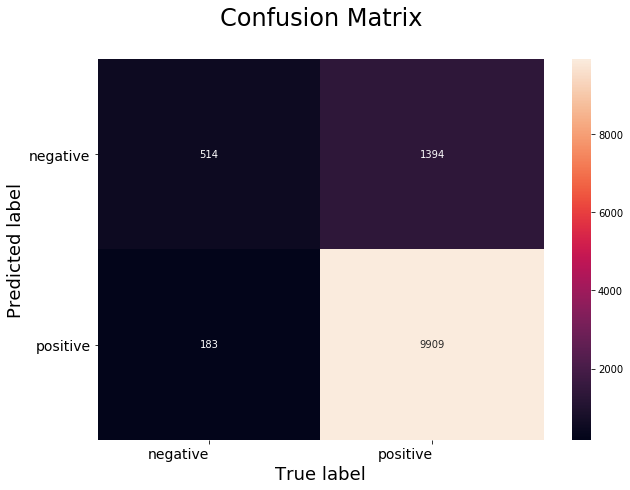

In [43]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (4). TFIDF-Word2Vec

In [44]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1  
    
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1    

# 3 Fold Cross-Validation (Brute force implementation)

In [45]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tfidf_train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 21.


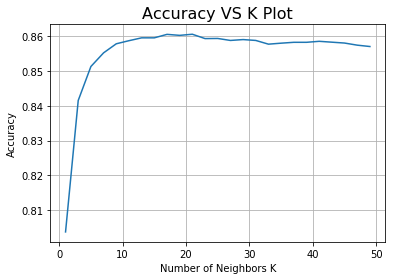


 Accuracy for each k value is :  [0.804 0.842 0.851 0.855 0.858 0.859 0.86  0.86  0.861 0.86  0.861 0.859
 0.859 0.859 0.859 0.859 0.858 0.858 0.858 0.858 0.859 0.858 0.858 0.857
 0.857]


In [46]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [47]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(tfidf_test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_brute_K = optimal_k
TFIDF_Word2Vec_brute_train_acc = max(cv_scores)*100
TFIDF_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 21 is 82.916667%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

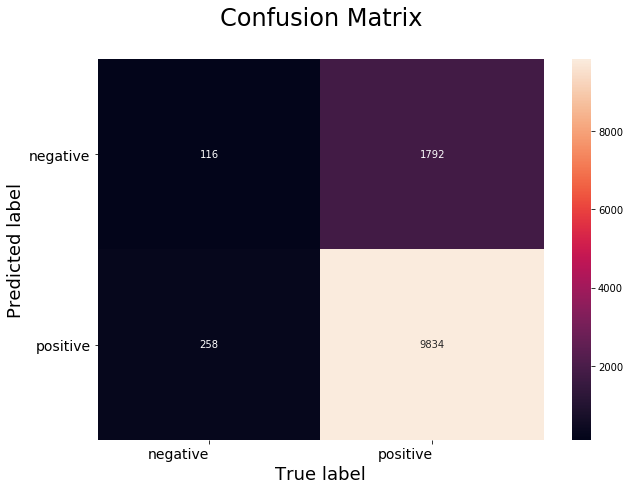

In [48]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3 Fold Cross-Validation (kd_tree implementation)

In [49]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, tfidf_train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 21.


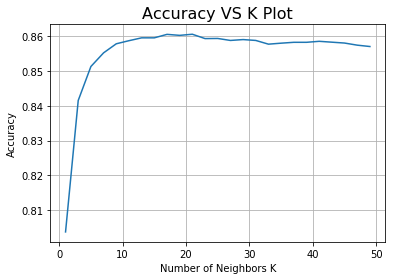


 Accuracy for each k value is :  [0.804 0.842 0.851 0.855 0.858 0.859 0.86  0.86  0.861 0.86  0.861 0.859
 0.859 0.859 0.859 0.859 0.858 0.858 0.858 0.858 0.859 0.858 0.858 0.857
 0.857]


In [50]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [51]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(tfidf_test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_kdTree_K = optimal_k
TFIDF_Word2Vec_kdTree_train_acc = max(cv_scores)*100
TFIDF_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 21 is 82.916667%


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

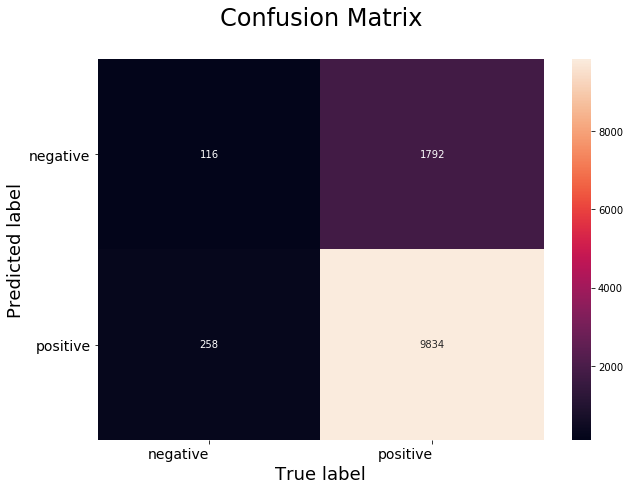

In [52]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION :

# (a). Procedure followed :

STEP 1 :- Text Preprocessing 

STEP 2:- Sorting the dataset on the basis of time , then randomly selecting 40K datapoints from whole dataset and split these datapoints into train_data and test_data

STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors

STEP 4:- Using KNN as an estimator in 3-Fold Cross-Validation in order to find optimal value of K .

STEP 5:- Draw "Accuracy VS K" plot 

STEP 6:- Once , we get optimal value of K then train KNN again with this optimal K and make predictions on test_data

STEP 7:- Compute test accuracy using predicted values and ground truth values of test_data

STEP 8:- Plot Seaborn Heatmap for representation of Confusion Matrix

Repeat from STEP 3 to STEP 7 for each of these four vectorizers : Bag Of Words(BoW), TFIDF , Avg Word2Vec and TFIDF Word2Vec

# (b). Table (Model Performances with their hyperparameters :

In [53]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["KNN using 'brute' for BoW", "KNN using 'kdTree' for BoW", "KNN using 'brute' for TFIDF", \
        "KNN using 'kdTree' for TFIDF", "KNN using 'brute' for Avg-Word2Vec", "KNN using 'kdTree' for Avg-Word2Vec", \
        "KNN using 'brute' for TFIDF-Word2Vec", "KNN using 'kdTree' for TFIDF-Word2Vec"]

optimal_K = [bow_brute_K, bow_kdTree_K, tfidf_brute_K, tfidf_kdTree_K, Avg_Word2Vec_brute_K, Avg_Word2Vec_kdTree_K, \
             TFIDF_Word2Vec_brute_K, TFIDF_Word2Vec_kdTree_K]

train_acc = [bow_brute_train_acc, bow_kdTree_train_acc, tfidf_brute_train_acc, tfidf_kdTree_train_acc, \
             Avg_Word2Vec_brute_train_acc, Avg_Word2Vec_kdTree_train_acc, TFIDF_Word2Vec_brute_train_acc, \
             TFIDF_Word2Vec_kdTree_train_acc]

test_acc = [bow_brute_test_acc, bow_kdTree_test_acc, tfidf_brute_test_acc, tfidf_kdTree_test_acc, \
            Avg_word2Vec_brute_test_acc, Avg_Word2Vec_kdTree_test_acc, TFIDF_word2Vec_brute_test_acc, \
            TFIDF_Word2Vec_kdTree_test_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",optimal_K)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+---------------------------------------+--------+-------------------+-------------------+
| S.NO. |                 MODEL                 | Best K | Training Accuracy |   Test Accuracy   |
+-------+---------------------------------------+--------+-------------------+-------------------+
|   1   |       KNN using 'brute' for BoW       |   9    | 84.64286336414708 | 84.48333333333333 |
|   2   |       KNN using 'kdTree' for BoW      |   19   | 84.95713198858216 |       85.075      |
|   3   |      KNN using 'brute' for TFIDF      |   13   |  85.346414390277  | 84.91666666666666 |
|   4   |      KNN using 'kdTree' for TFIDF     |   45   | 85.91427842717621 |        85.6       |
|   5   |   KNN using 'brute' for Avg-Word2Vec  |   15   |  86.6035585358501 | 86.85833333333333 |
|   6   |  KNN using 'kdTree' for Avg-Word2Vec  |   15   |  86.6035585358501 | 86.85833333333333 |
|   7   |  KNN using 'brute' for TFIDF-Word2Vec |   21   | 86.06070648985852 | 82.91666666666667 |
|   8   | 